# Titanic – regresja logistyczna





In [1]:
# 1) Importy
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


## 1.2 Wczytanie danych

In [2]:
df = sns.load_dataset("titanic")
print(df.shape)
df.head()


(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 2.1 Część 1: Eksploracja danych

### 1.1 Podstawowe statystyki (`describe()`, `info()`)

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who,891,3,man,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2 Brakujące wartości w każdej kolumnie

In [5]:
missing = df.isna().sum().sort_values(ascending=False)
missing


,0
deck,688
age,177
embarked,2
embark_town,2
sex,0
pclass,0
survived,0
fare,0
parch,0
sibsp,0


### 1.3 Proporcja osób, które przeżyły
- ogółem
- w podziale na płeć
- w podziale na klasę


In [6]:
survival_overall = df["survived"].mean()
survival_by_sex = df.groupby("sex")["survived"].mean().sort_values(ascending=False)
survival_by_class = df.groupby("pclass")["survived"].mean().sort_values(ascending=False)

print(f"Proporcja ocalałych (ogółem): {survival_overall:.3f}")
print("\nProporcja ocalałych wg płci:")
print(survival_by_sex)
print("\nProporcja ocalałych wg klasy biletu (pclass):")
print(survival_by_class)


Proporcja ocalałych (ogółem): 0.384

Proporcja ocalałych wg płci:
sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

Proporcja ocalałych wg klasy biletu (pclass):
pclass
1    0.629630
2    0.472826
3    0.242363
Name: survived, dtype: float64


Dodatkowo: przeżywalność w podziale na **płeć i klasę**.

In [7]:
survival_sex_class = df.pivot_table(values="survived", index="sex", columns="pclass", aggfunc="mean")
survival_sex_class


pclass,1,2,3
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


### 1.4 Wykres przeżywalności w zależności od płci i klasy

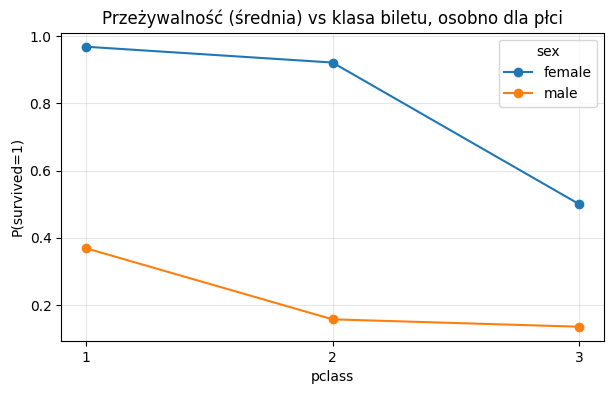

In [8]:
# Wykres słupkowy: przeżywalność (średnia z survived) dla kombinacji sex × pclass
plot_df = df.groupby(["sex", "pclass"], as_index=False)["survived"].mean()

fig, ax = plt.subplots(figsize=(7,4))
for sex in plot_df["sex"].unique():
    sub = plot_df[plot_df["sex"] == sex]
    ax.plot(sub["pclass"], sub["survived"], marker="o", label=sex)

ax.set_title("Przeżywalność (średnia) vs klasa biletu, osobno dla płci")
ax.set_xlabel("pclass")
ax.set_ylabel("P(survived=1)")
ax.set_xticks([1,2,3])
ax.grid(True, alpha=0.3)
ax.legend(title="sex")
plt.show()


## 2.2 Część 2: Przygotowanie danych

### 2.1 Usunięcie kolumn nieprzydatnych
Przykładowo `deck` ma dużo braków, a `alive` jest wprost powiązane z `survived` (ryzyko "wycieku" informacji). Usuniemy też identyfikatory tekstowe (`who`, `adult_male`, `embark_town`, `class` – zostawimy `pclass` jako liczbową), aby uprościć model.

### 2.2 Uzupełnienie braków w `age` medianą

### 2.3 One-hot encoding dla zmiennych kategorycznych

### 2.4 Podział train/test 80/20 z `stratify`

In [9]:
# Zmienna docelowa
y = df["survived"]

# Kolumny do odrzucenia (możesz modyfikować listę – tu wariant rozsądny do regresji logistycznej)
drop_cols = [
    "survived",   # target
    "deck",       # dużo braków
    "alive",      # informacja prawie identyczna jak target
    "embark_town",# redundantne względem embarked
    "class",      # redundantne względem pclass (i mieszanie typów)
    "who",        # pochodna płci i wieku
    "adult_male"  # pochodna płci i wieku
]

X = df.drop(columns=drop_cols)

# Szybka kontrola
X.head()


,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,3,male,22.0,1,0,7.2500,S,False
1,1,female,38.0,1,0,71.2833,C,False
2,3,female,26.0,0,0,7.9250,S,True
3,1,female,35.0,1,0,53.1000,S,False
4,3,male,35.0,0,0,8.0500,S,True


In [10]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Proporcja survived w train:", y_train.mean().round(3))
print("Proporcja survived w test :", y_test.mean().round(3))


Train: (712, 8)  Test: (179, 8)
Proporcja survived w train: 0.383
Proporcja survived w test : 0.385


Zbudujemy **pipeline**: imputacja braków + one-hot dla kategorycznych + regresja logistyczna.

- numeryczne: imputacja medianą
- kategoryczne: imputacja najczęstszą wartością + one-hot


In [11]:
# Wykrycie typów kolumn
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols, num_cols


(['sex', 'embarked', 'alone'], ['pclass', 'age', 'sibsp', 'parch', 'fare'])

In [12]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# Model bazowy (bez standaryzacji – standaryzację zrobimy później w eksperymentach z regularyzacją)
base_model = LogisticRegression(max_iter=2000)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", base_model)
])

clf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embarked',
                                                   'alone'])])),
                ('model', LogisticRegression(max_iter=2000))])

## 2.3 Część 3: Budowa modelu
### 3.1 Trenowanie modelu

In [13]:
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embarked',
                                                   'alone'])])),
                ('model', LogisticRegression(max_iter=2000))])

### 3.2 Współczynniki i interpretacja 3 najważniejszych zmiennych
W regresji logistycznej współczynnik β oznacza zmianę **log-ilorazu szans** (log-odds) przy wzroście zmiennej o 1 (dla zmiennych numerycznych) lub przy przejściu z kategorii bazowej do danej kategorii (dla one-hot).

In [14]:
# Pobranie nazw cech po transformacji (numeryczne + one-hot)
feature_names_num = num_cols
feature_names_cat = clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)

feature_names = np.concatenate([feature_names_num, feature_names_cat])

coefs = clf.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "beta": coefs})
coef_df["abs_beta"] = coef_df["beta"].abs()
coef_df_sorted = coef_df.sort_values("abs_beta", ascending=False)

coef_df_sorted.head(15)


,feature,beta,abs_beta
6,sex_male,-1.273672,1.273672
5,sex_female,1.271947,1.271947
0,pclass,-1.059184,1.059184
2,sibsp,-0.405308,0.405308
8,embarked_Q,0.344291,0.344291
9,embarked_S,-0.333099,0.333099
11,alone_True,-0.306672,0.306672
10,alone_False,0.304947,0.304947
3,parch,-0.208600,0.208600
1,age,-0.037740,0.037740


In [15]:
top3 = coef_df_sorted.head(3)[["feature","beta"]]
top3


,feature,beta
6,sex_male,-1.273672
5,sex_female,1.271947
0,pclass,-1.059184


**Interpretacja (automatycznie na podstawie znaków β):**
- β > 0: rośnie szansa przeżycia (większe log-odds / większe odds)
- β < 0: maleje szansa przeżycia

Poniższa komórka drukuje krótką interpretację top-3.

In [16]:
for _, row in top3.iterrows():
    feat, beta = row["feature"], row["beta"]
    direction = "zwiększa" if beta > 0 else "zmniejsza"
    print(f"- {feat}: beta={beta:.3f} → {direction} szanse przeżycia (przy pozostałych cechach stałych).")


- sex_male: beta=-1.274 → zmniejsza szanse przeżycia (przy pozostałych cechach stałych).
- sex_female: beta=1.272 → zwiększa szanse przeżycia (przy pozostałych cechach stałych).
- pclass: beta=-1.059 → zmniejsza szanse przeżycia (przy pozostałych cechach stałych).


### 3.3 Odds ratio dla każdej zmiennej + interpretacja dla `sex`
Odds ratio = exp(β). Jeśli OR > 1, to szanse przeżycia rosną; jeśli OR < 1, to maleją.

In [17]:
coef_df["odds_ratio"] = np.exp(coef_df["beta"])
coef_df.sort_values("odds_ratio", ascending=False).head(15)


,feature,beta,abs_beta,odds_ratio
5,sex_female,1.271947,1.271947,3.567791
8,embarked_Q,0.344291,0.344291,1.410989
10,alone_False,0.304947,0.304947,1.356552
4,fare,0.001869,0.001869,1.001870
7,embarked_C,-0.012917,0.012917,0.987166
1,age,-0.037740,0.037740,0.962963
3,parch,-0.208600,0.208600,0.811720
11,alone_True,-0.306672,0.306672,0.735892
9,embarked_S,-0.333099,0.333099,0.716699
2,sibsp,-0.405308,0.405308,0.666771


In [18]:
# Wiersze związane z płcią (zależy od kodowania one-hot; zwykle pojawi się np. 'sex_male' albo 'sex_female')
sex_rows = coef_df[coef_df["feature"].str.startswith("sex_")].copy()
sex_rows


,feature,beta,abs_beta,odds_ratio
5,sex_female,1.271947,1.271947,3.567791
6,sex_male,-1.273672,1.273672,0.279802


**Jak to czytać dla `sex`:**

- Jeśli mamy cechę `sex_male` (1 = mężczyzna, 0 = nie), to:
  - OR < 1 oznacza, że bycie mężczyzną **zmniejsza** szanse przeżycia względem kategorii bazowej (zwykle kobiet).
  - OR > 1 oznacza, że bycie mężczyzną **zwiększa** szanse przeżycia.
- Analogicznie dla `sex_female`.

Poniżej wypisujemy konkretną wartość OR z modelu:

In [19]:
for _, row in sex_rows.iterrows():
    print(f"{row['feature']}: beta={row['beta']:.3f}, OR=exp(beta)={row['odds_ratio']:.3f}")


sex_female: beta=1.272, OR=exp(beta)=3.568
sex_male: beta=-1.274, OR=exp(beta)=0.280


## 2.4 Część 4: Ewaluacja modelu
### 4.1 Predykcja na zbiorze testowym

In [20]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]


### 4.2 Macierz konfuzji (tabela i wizualizacja)

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[97, 13],
       [22, 47]])

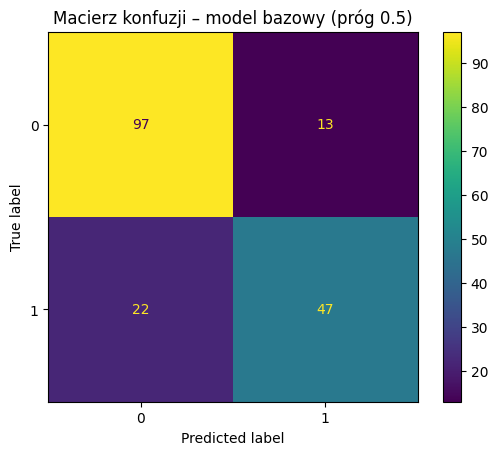

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title("Macierz konfuzji – model bazowy (próg 0.5)")
plt.show()


### 4.3 Metryki: Accuracy, Precision, Recall, F1, Specificity
- **Accuracy**: odsetek poprawnych klasyfikacji
- **Precision**: wśród przewidzianych jako 1, jaki odsetek naprawdę jest 1
- **Recall (czułość)**: wśród prawdziwych 1, jaki odsetek wykryliśmy
- **F1**: średnia harmoniczna precision i recall
- **Specificity (swoistość)**: wśród prawdziwych 0, jaki odsetek poprawnie rozpoznaliśmy jako 0

In [23]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan

metrics = pd.DataFrame({
    "metryka": ["Accuracy", "Precision", "Recall", "F1-score", "Specificity"],
    "wartość": [acc, prec, rec, f1, spec]
})
metrics


,metryka,wartość
0,Accuracy,0.804469
1,Precision,0.783333
2,Recall,0.681159
3,F1-score,0.728682
4,Specificity,0.881818


### 4.4 Krzywa ROC + AUC

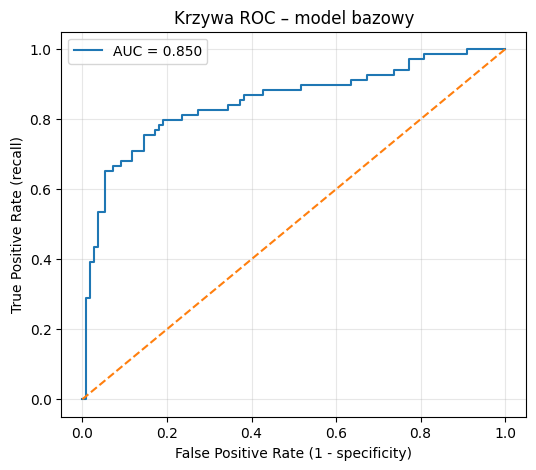

np.float64(0.8503293807641634)

In [24]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate (1 - specificity)")
plt.ylabel("True Positive Rate (recall)")
plt.title("Krzywa ROC – model bazowy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

auc


### 4.5 Która metryka jest najważniejsza i dlaczego?
W tym zadaniu zwykle najbardziej sensowna jest **Recall (czułość)** lub **F1** – zależnie od tego, czy bardziej przeszkadza nam:
- **fałszywe pominięcie ocalałego** (FN) → wtedy pilnujemy wysokiego Recall,
- czy **równowaga** między wykrywaniem ocalałych a ograniczaniem fałszywych alarmów → wtedy F1.

Ponieważ zbiór Titanic ma umiarkowaną nierównowagę klas i często interesuje nas "wyłapanie" jak największej liczby ocalałych, praktycznym wyborem bywa **Recall** (plus kontrola Precision).

## 2.5 Część 5: Eksperymenty
### 5.1 Recall i Precision dla progów 0.3–0.7

In [25]:
thresholds_to_check = [0.3, 0.4, 0.5, 0.6, 0.7]

rows = []
for th in thresholds_to_check:
    y_pred_th = (y_proba >= th).astype(int)
    rows.append({
        "próg": th,
        "precision": precision_score(y_test, y_pred_th, zero_division=0),
        "recall": recall_score(y_test, y_pred_th, zero_division=0),
        "f1": f1_score(y_test, y_pred_th, zero_division=0)
    })

pd.DataFrame(rows)


,próg,precision,recall,f1
0,0.3,0.666667,0.811594,0.732026
1,0.4,0.732394,0.753623,0.742857
2,0.5,0.783333,0.681159,0.728682
3,0.6,0.877551,0.623188,0.728814
4,0.7,0.880952,0.536232,0.666667


### 5.2 Model z `class_weight='balanced'` i porównanie z bazowym

In [26]:
balanced_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

balanced_clf.fit(X_train, y_train)

y_pred_bal = balanced_clf.predict(X_test)
y_proba_bal = balanced_clf.predict_proba(X_test)[:, 1]

cm_bal = confusion_matrix(y_test, y_pred_bal)
tn, fp, fn, tp = cm_bal.ravel()
spec_bal = tn / (tn + fp)

metrics_bal = {
    "Accuracy": accuracy_score(y_test, y_pred_bal),
    "Precision": precision_score(y_test, y_pred_bal, zero_division=0),
    "Recall": recall_score(y_test, y_pred_bal, zero_division=0),
    "F1-score": f1_score(y_test, y_pred_bal, zero_division=0),
    "Specificity": spec_bal,
    "AUC": roc_auc_score(y_test, y_proba_bal)
}

metrics_base = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "Specificity": spec,
    "AUC": auc
}

compare = pd.DataFrame([metrics_base, metrics_bal], index=["bazowy", "balanced"])
compare


,Accuracy,Precision,Recall,F1-score,Specificity,AUC
bazowy,0.804469,0.783333,0.681159,0.728682,0.881818,0.850329
balanced,0.793296,0.722222,0.753623,0.737589,0.818182,0.849934


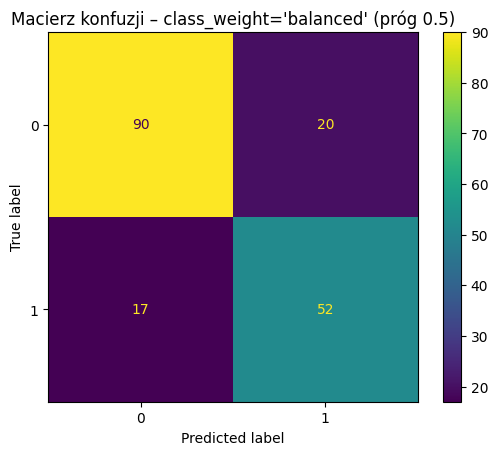

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bal, display_labels=[0,1])
disp.plot()
plt.title("Macierz konfuzji – class_weight='balanced' (próg 0.5)")
plt.show()


## 6. Regularyzacja i standaryzacja
### 6.1 Standaryzacja danych
Standaryzujemy **zmienne numeryczne** przez `StandardScaler`, dopasowany tylko na train (pipeline o to dba).

In [28]:
# Pipeline: preprocess (imputacja + one-hot) -> scaler -> model
# UWAGA: StandardScaler nie działa na macierzy rzadkiej (sparse) wprost, więc ustawimy:
# - OneHotEncoder(sparse_output=True) (domyślnie może być rzadkie),
# - StandardScaler(with_mean=False) aby współpracował z macierzą rzadką.

categorical_transformer_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # będzie sparse
])

preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", categorical_transformer_scaled, cat_cols)
    ],
    remainder="drop"
)

# scaler dla całości po ColumnTransformer nie jest konieczny, bo numeryczne już są skalowane;
# kategoryczne (0/1) zostawiamy bez skalowania.


### 6.2 Wpływ parametru C (L2)
Dla C ∈ {0.001, 0.01, 0.1, 1, 10, 100} liczymy:
- AUC na teście
- sumę |β|

In [29]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]

results = []
coef_sums = []

for C in Cs:
    model = LogisticRegression(max_iter=3000, penalty="l2", C=C)
    pipe = Pipeline(steps=[
        ("preprocess", preprocess_scaled),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    auc_c = roc_auc_score(y_test, proba)

    # suma |beta| (po dopasowaniu)
    betas = pipe.named_steps["model"].coef_.ravel()
    sum_abs = np.abs(betas).sum()

    results.append({"C": C, "AUC": auc_c, "sum_abs_beta": sum_abs})

res_df = pd.DataFrame(results)
res_df


,C,AUC,sum_abs_beta
0,0.001,0.795784,0.489545
1,0.010,0.833992,2.248253
2,0.100,0.850725,4.782600
3,1.000,0.850066,5.915227
4,10.000,0.849934,6.127845
5,100.000,0.849934,6.149115


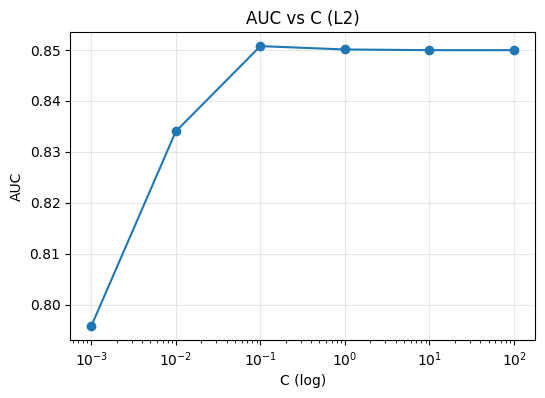

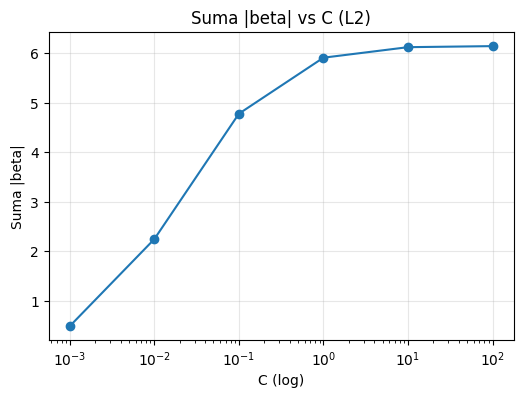

In [30]:
# Wykresy zależności AUC i sumy |beta| od C (skala log na osi X dla czytelności)
plt.figure(figsize=(6,4))
plt.plot(res_df["C"], res_df["AUC"], marker="o")
plt.xscale("log")
plt.xlabel("C (log)")
plt.ylabel("AUC")
plt.title("AUC vs C (L2)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(res_df["C"], res_df["sum_abs_beta"], marker="o")
plt.xscale("log")
plt.xlabel("C (log)")
plt.ylabel("Suma |beta|")
plt.title("Suma |beta| vs C (L2)")
plt.grid(True, alpha=0.3)
plt.show()


### 6.3 L1 vs L2 dla C = 0.1
Porównujemy współczynniki modeli:
- L2: `penalty='l2'`
- L1: `penalty='l1', solver='liblinear'`

L1 ma tendencję do zerowania części współczynników (selekcja cech).

In [31]:
C = 0.1

pipe_l2 = Pipeline(steps=[
    ("preprocess", preprocess_scaled),
    ("model", LogisticRegression(max_iter=5000, penalty="l2", C=C))
])

pipe_l1 = Pipeline(steps=[
    ("preprocess", preprocess_scaled),
    ("model", LogisticRegression(max_iter=5000, penalty="l1", C=C, solver="liblinear"))
])

pipe_l2.fit(X_train, y_train)
pipe_l1.fit(X_train, y_train)

# Nazwy cech po preprocess_scaled
feature_names_num = num_cols  # numeryczne po imputacji+scaler mają te same nazwy
feature_names_cat = pipe_l2.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

coef_l2 = pipe_l2.named_steps["model"].coef_.ravel()
coef_l1 = pipe_l1.named_steps["model"].coef_.ravel()

compare_coef = pd.DataFrame({
    "feature": feature_names,
    "beta_L2": coef_l2,
    "beta_L1": coef_l1,
    "abs_L2": np.abs(coef_l2),
    "abs_L1": np.abs(coef_l1),
    "is_zero_L1": np.isclose(coef_l1, 0.0)
}).sort_values("abs_L2", ascending=False)

compare_coef.head(20)


,feature,beta_L2,beta_L1,abs_L2,abs_L1,is_zero_L1
6,sex_male,-1.058867,-1.305166,1.058867,1.305166,False
5,sex_female,1.058794,0.888443,1.058794,0.888443,False
0,pclass,-0.726551,-0.764318,0.726551,0.764318,False
1,age,-0.394560,-0.321338,0.394560,0.321338,False
2,sibsp,-0.317714,-0.119043,0.317714,0.119043,False
9,embarked_S,-0.257552,-0.113963,0.257552,0.113963,False
11,alone_True,-0.231658,0.000000,0.231658,0.000000,True
10,alone_False,0.231585,0.000000,0.231585,0.000000,True
8,embarked_Q,0.199859,0.000000,0.199859,0.000000,True
4,fare,0.132914,0.036894,0.132914,0.036894,False


In [32]:
# Ile współczynników wyzerowało L1?
compare_coef["is_zero_L1"].mean(), compare_coef["is_zero_L1"].sum(), compare_coef.shape[0]


(np.float64(0.4166666666666667), np.int64(5), 12)